# PyTorch Convolutional Neural Network for CIFAR-10 Dataset

In order to get more experience with image classification, I will be creating a convolutional neural network with PyTorch and applying it to the CIFAR-10 dataset. The CIFAR-10 classification dataset consists of 60,000 labelled images split between 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

### CNN Architecture

Each image consists of 32x32 RGB pixel values between 0 and 255. We do not need to perform any preprocessing as the convolutional model will use all three channels concurrently as input.

The architecture in use has 14 layers: three convolution layers followed by a pooling layer repeated  twice, two convolutional layers followed by a pooling layer, then three fully connected dense layers. The latter of these has 10 neurons to provide classification output.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
torch.set_num_threads(4) #Sets the number of threads used for intraop parallelism on CPU.
torch.set_num_interop_threads(4) #Sets the number of threads used for interop parallelism (e.g. in JIT interpreter) on CPU.

## Data Augmentation and Transformations

Each image in the training and test datasets need to be converted to tensor before torch can process them. Image pixel intensity will be normalized, which helps the model learn better.

In order to prevent overfitting, data augmentation will also be applied to the training images in the form of random flipping and color jittering. Doing so maintains the label and helps the model to generalize better to more variations of each class, and the augmentations aren't extreme enough for the images to lose key features.

In [3]:
trainTransform = transforms.Compose([
                                      torchvision.transforms.ColorJitter(brightness=.05, saturation=0.5, contrast=0.5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      ])

testTransform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      ])

In [4]:
#Pytorch has made the CIFAR-10 dataset easy to access... Load the train and test datasets, and apply the transformations
root_dir = './'
trainDataset = torchvision.datasets.CIFAR10(root=root_dir, train=True, download=True, transform=trainTransform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=10, shuffle=True, pin_memory=True) #Work with 10 images at a time...
testDataset = torchvision.datasets.CIFAR10(root=root_dir, train=False, download=True, transform=testTransform)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=10, shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Display Images being Processed

To give a better sense of what kind of images are being processed, a sample images from the training dataset are converted to numpy and plotted... The resolution of the CIFAR-10 images is very low, but the images are still distinguishable.

In [5]:
classes = trainDataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

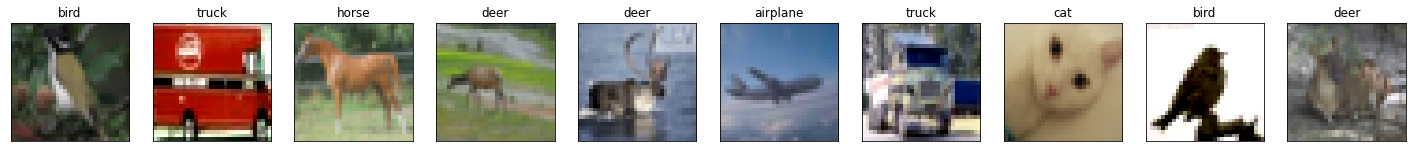

In [6]:
#Visualize un-transformed dataset
# We need to convert the images to numpy arrays in order to be matplotlib compatible.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

dataiter = iter(trainLoader) . 
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4)) 

for idx in np.arange(10):
  ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])).
  ax.set_title(classes[labels[idx].item()])

## Create Model

Through trial and error, it was found that adding more convolution layers, batch normalizing them, and using more and more spatial filters allowed for the model to better minimize loss and achieve better accuracy on the test set. The spatial filters allow for preservation of their input's spatial structure, and the size determines how many local features are extracted from the image when the filters are applied. Adding more convolution layers allows for higher, more-complex features to be learned, and batch normalization helps stabilize the training procedure by re-centering and re-scaling inputs to prevent internal covariate shift.

The first hidden layer size was chosen to provide a neuron for each value of the final, flattened activation map of the last convolution layer, and the next hidden layer was of the same size. Having a second hidden layer before the final output allows for even more complex features to be extracted, although the high amount of neurons makes training time slow. The third and last hidden layer has one neuron for each type of classification.



In [7]:
class CNNModel(nn.Module):
    def __init__(self, dropoutRate, activate):
        super().__init__()
        #self.outChannels = outChannels
        self.activate = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=160, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(160)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=160, out_channels=288, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(288)
        self.conv3 = nn.Conv2d(in_channels=288, out_channels=352, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(352)
        self.conv4 = nn.Conv2d(in_channels=352, out_channels=416, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(416)
        self.conv5 = nn.Conv2d(in_channels=416, out_channels=480, kernel_size=3)
        self.batchnorm5 = nn.BatchNorm2d(480)
        self.conv6 = nn.Conv2d(in_channels=480, out_channels=544, kernel_size=3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(544)
        self.conv7 = nn.Conv2d(in_channels=544, out_channels=608, kernel_size=3, padding=1)
        self.batchnorm7 = nn.BatchNorm2d(608)
        self.conv8 = nn.Conv2d(in_channels=608, out_channels=672, kernel_size=3)
        self.batchnorm8 = nn.BatchNorm2d(672)
        self.dense1 = nn.Linear(672 *2 * 2, 2688) #First FC layer will have 4608 neurons
        self.densemiddle = nn.Linear(2688, 2688) #New, middle layer will also have 4608 neurons
        self.dropout = nn.Dropout(dropoutRate)
        self.dense2 = nn.Linear(2688, 10)

    def forward(self, x):
        x = self.activate(self.batchnorm1(self.conv1(x))) #Output 32 x 32 x 160
        x = self.activate(self.batchnorm2(self.conv2(x))) #Output 32 x 32 x 288
        x = self.pool(self.activate(self.batchnorm3(self.conv3(x)))) #Output 16 x 16 x 352
        x = self.activate(self.batchnorm4(self.conv4(x))) #Output 16 x 16 x 416
        x = self.activate(self.batchnorm5(self.conv5(x))) #Output 14 x 14 x 480
        x = self.pool(self.activate(self.batchnorm6(self.conv6(x)))) #Output 6 x 6 x 544
        x = self.activate(self.batchnorm7(self.conv7(x))) #Output 6 x 6 x 608
        x = self.pool(self.activate(self.batchnorm8(self.conv8(x)))) #Output 2 x 2 x 672
        x = x.view(-1, 672 * 2 * 2)
        x = self.dropout(self.activate(self.dense1(x)))
        x = self.dropout(self.activate(self.densemiddle(x)))
        return self.dense2(x)

## Train and Test the model

15 training epochs are used to allow for enough training of the model without overfitting and unneccessary waiting. A dropout rate of 0.1 is also used on the fully-connected layers to provide regularization, which mitigates overfitting by randomly choosing 10% of nodes in each layer to not activate on a give training epoch. Doing so forces the model not to be overly-reliant on a given node.

In [8]:
# Dropout rate
dropoutRate = 0.5
# Activation function
activation = "ReLU"
# Learning rate
learningRate = 0.001
# Momentum for SGD optimizer
momentum = 0.9
# Number of training epochs
numEpochs = 20

In [9]:
#Get PyTorch to recognize and use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

cnn = CNNModel(dropoutRate, activation)
cnn.to(device)

criterion = nn.CrossEntropyLoss() #Entropy loss is better for classification problems than, say, MSE
optimizer = torch.optim.SGD(list(cnn.parameters()), lr=learningRate, momentum=momentum)

print('>>> Beginning training!') 
cnn.train()
for epoch in range(numEpochs):  # loop over the dataset multiple times
    cnnRunningLoss = 0
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        
        optimizer.zero_grad()

        # Forward propagation
        cnnOutputs = cnn(inputs.to(device))
        
        # Backpropagation
        cnnLoss = criterion(cnnOutputs, labels.to(device))
        cnnLoss.backward()
        
        # Gradient update
        optimizer.step()

        cnnRunningLoss += cnnLoss.item()
        if (i+1) % 2000 == 0:    # print every 2000 mini-batches
            print('Epoch [{}/{}], Step [{}/{}], CNN Loss: {}'.format(epoch + 1, numEpochs, i + 1, len(trainDataset)//10, cnnRunningLoss/2000))
            cnnRunningLoss = 0

print()
print('>>> Beginning validation!')
cnn.eval()
cnnCorrect = 0
total = 0
for inputs, labels in testLoader:
    cnnOutputs = cnn(inputs.to(device))
    _, cnnPredicted = torch.max(cnnOutputs.data, 1)
    total += labels.to(device).size(0)
    cnnCorrect += (cnnPredicted == labels.to(device)).sum().item()
print('CNN validation accuracy: {}%'.format(cnnCorrect / total * 100))

>>> Beginning training!
Epoch [1/20], Step [2000/5000], CNN Loss: 1.6402534750252962
Epoch [1/20], Step [4000/5000], CNN Loss: 1.1350352380275726
Epoch [2/20], Step [2000/5000], CNN Loss: 0.8280267246514559
Epoch [2/20], Step [4000/5000], CNN Loss: 0.7361387716718018
Epoch [3/20], Step [2000/5000], CNN Loss: 0.622887347644195
Epoch [3/20], Step [4000/5000], CNN Loss: 0.5618953163460828
Epoch [4/20], Step [2000/5000], CNN Loss: 0.49581633995031005
Epoch [4/20], Step [4000/5000], CNN Loss: 0.4706928260163404
Epoch [5/20], Step [2000/5000], CNN Loss: 0.39976351014664396
Epoch [5/20], Step [4000/5000], CNN Loss: 0.4036167171059642
Epoch [6/20], Step [2000/5000], CNN Loss: 0.34088986032642427
Epoch [6/20], Step [4000/5000], CNN Loss: 0.3469694564747624
Epoch [7/20], Step [2000/5000], CNN Loss: 0.28783495661691993
Epoch [7/20], Step [4000/5000], CNN Loss: 0.29622035515739115
Epoch [8/20], Step [2000/5000], CNN Loss: 0.24541902159311577
Epoch [8/20], Step [4000/5000], CNN Loss: 0.251378209235

After training the CNN, the model was able to accurately classify 90% of images in the test set. Top-of-the-line models get above 94% accuracy, despite the low resolution of the images, so this CNN has much room for improvement. Changes that could be made include adding even more convolution layers, increasing the amount of spatial filters that are used, increasing the amount of training epochs and monitoring for overfitting, and optimizing the dropout parameter used. However, those changes would come at the expense of longer training times.

For fun, the classifier is tested on the first ten images of the test dataset with the labels of predicted vs actual being given. It's a 9/10 chance that this particular model classifies the image correctly, so this was a lucky run!

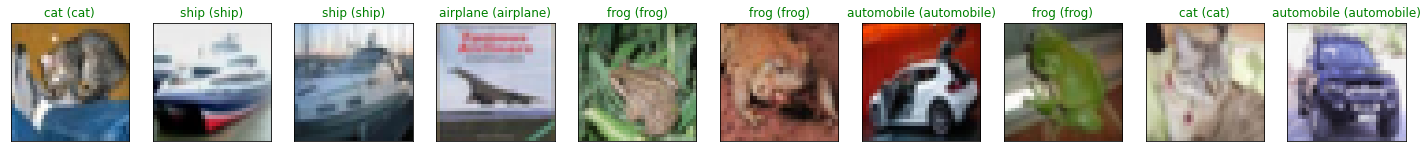

In [10]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = cnn(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))